W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 사용 폰트: NanumGothic


/tmp/ipython-input-3449846218.py:58: UserWarning: Glyph 10004 (\N{HEAVY CHECK MARK}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10004 (\N{HEAVY CHECK MARK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


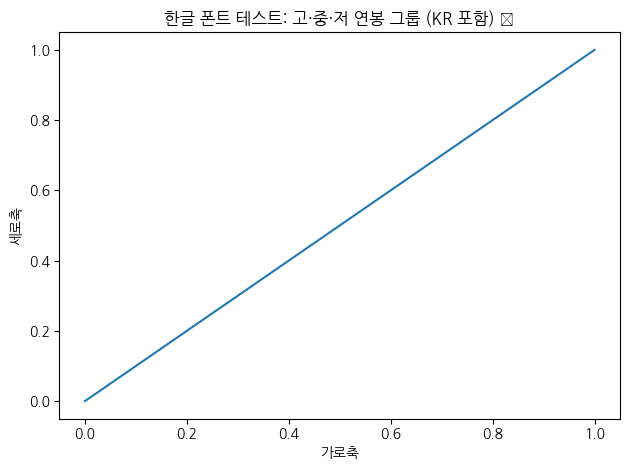

In [9]:
# =====================================================
# ✅ Colab 한글 폰트 완전 고정 템플릿 (자동 탐지·자동 선택)
# 런타임 세션 다시 시작후 코드 입력
# =====================================================
!apt-get update -qq > /dev/null
!apt-get install -y fonts-noto-cjk fonts-nanum > /dev/null
!fc-cache -fv > /dev/null

import os, glob, shutil
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1) matplotlib 폰트 캐시 폴더 보장 + 기존 캐시 파일 정리
cache_dir = os.path.join(os.path.expanduser("~"), ".cache", "matplotlib")
os.makedirs(cache_dir, exist_ok=True)
for f in glob.glob(os.path.join(cache_dir, "fontlist-*.json*")):
    try:
        os.remove(f)
    except FileNotFoundError:
        pass

# 2) 시스템 폰트 목록 새로 읽기
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')  # 있으면 등록
# (Noto CJK는 패키지 설치 시 자동 등록됨)

# 3) 사용 가능한 한글 폰트 자동 탐지
candidates = [
    "NanumGothic",
    "Noto Sans CJK KR",   # 권장
    "Noto Sans CJK",      # 일부 배포판에서 이 이름으로만 잡힐 수 있음
    "Noto Sans CJK SC",   # 혹시 중국어 패키지만 깔렸을 때 대체
]
available = {f.name for f in fm.fontManager.ttflist}
chosen = None
for name in candidates:
    if any(name == a or name in a for a in available):
        chosen = name
        break
if chosen is None:
    chosen = "DejaVu Sans"  # 최후의 안전장치(한글 미지원)

# 4) 전역 폰트 설정 (FontProperties 객체 사용 안 함 → TypeError 예방)
plt.rcParams.update({
    "font.family": chosen,
    "font.sans-serif": [chosen],
    "axes.unicode_minus": False,
    "font.size": 10,
})

print("✅ 사용 폰트:", chosen)
# 간단 테스트
plt.figure()
plt.title("한글 폰트 테스트: 고·중·저 연봉 그룹 (KR 포함) ✔")
plt.plot([0,1],[0,1])
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.tight_layout()
plt.show()

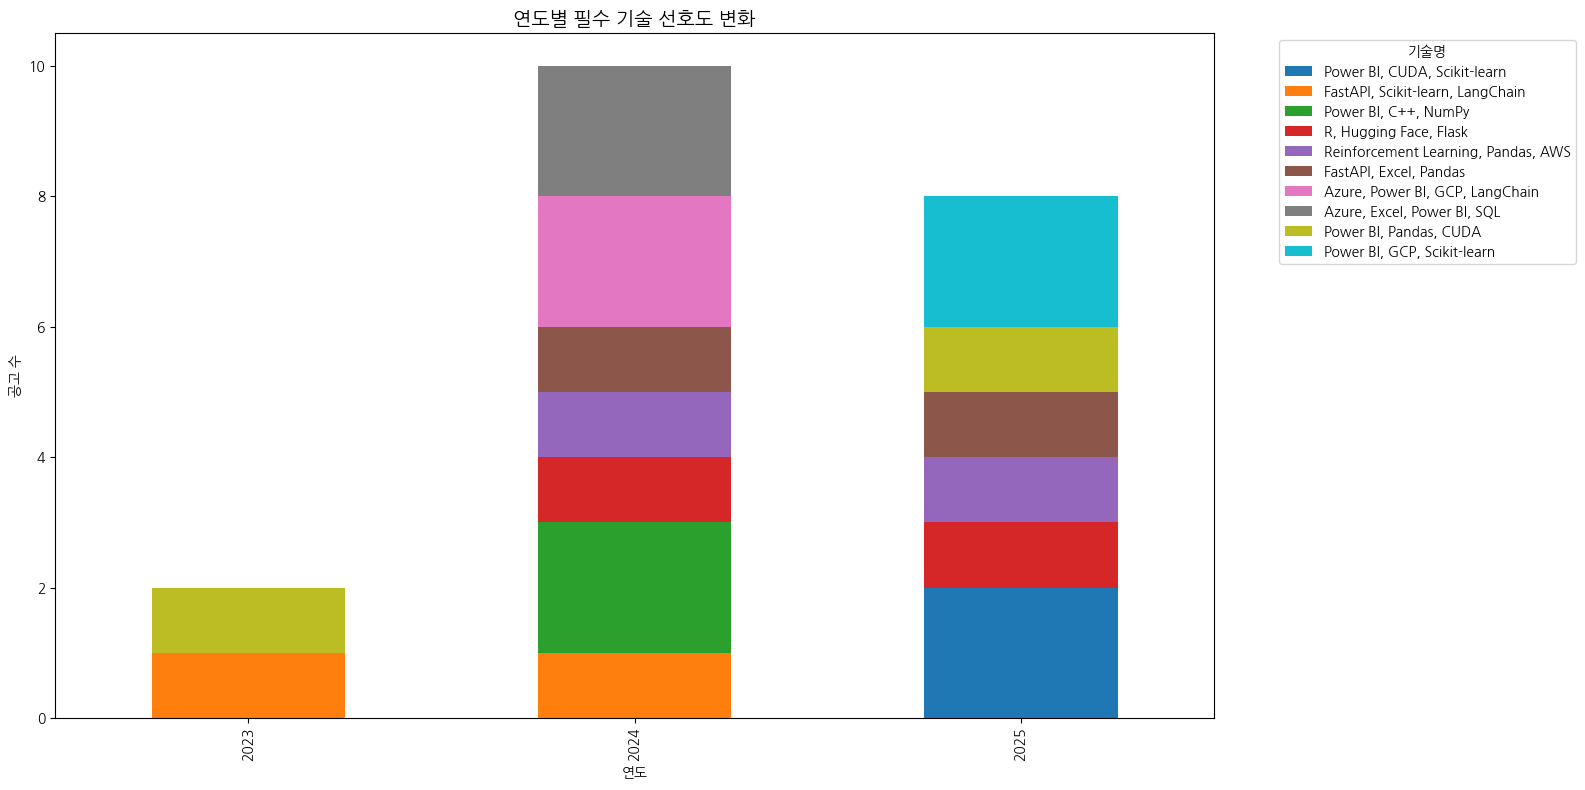

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 불러오기
df = pd.read_csv("ai_job_market.csv")

# 날짜 형식 변환
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')

# 결측치 제거
df = df.dropna(subset=['posted_date', 'skills_required'])

# 연도별, 기술별로 공고 수 계산
skills_by_year = df.groupby(df['posted_date'].dt.year)['skills_required'].value_counts().unstack(fill_value=0)

# 상위 10개 기술만 선택
top_skills = skills_by_year.sum().sort_values(ascending=False).head(10).index
skills_by_year = skills_by_year[top_skills]

# 그래프 그리기
skills_by_year.plot(kind='bar', stacked=True, colormap='tab10', figsize=(16, 8))
plt.title("연도별 필수 기술 선호도 변화", fontsize=14)
plt.xlabel("연도")
plt.ylabel("공고 수")
plt.legend(title="기술명", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

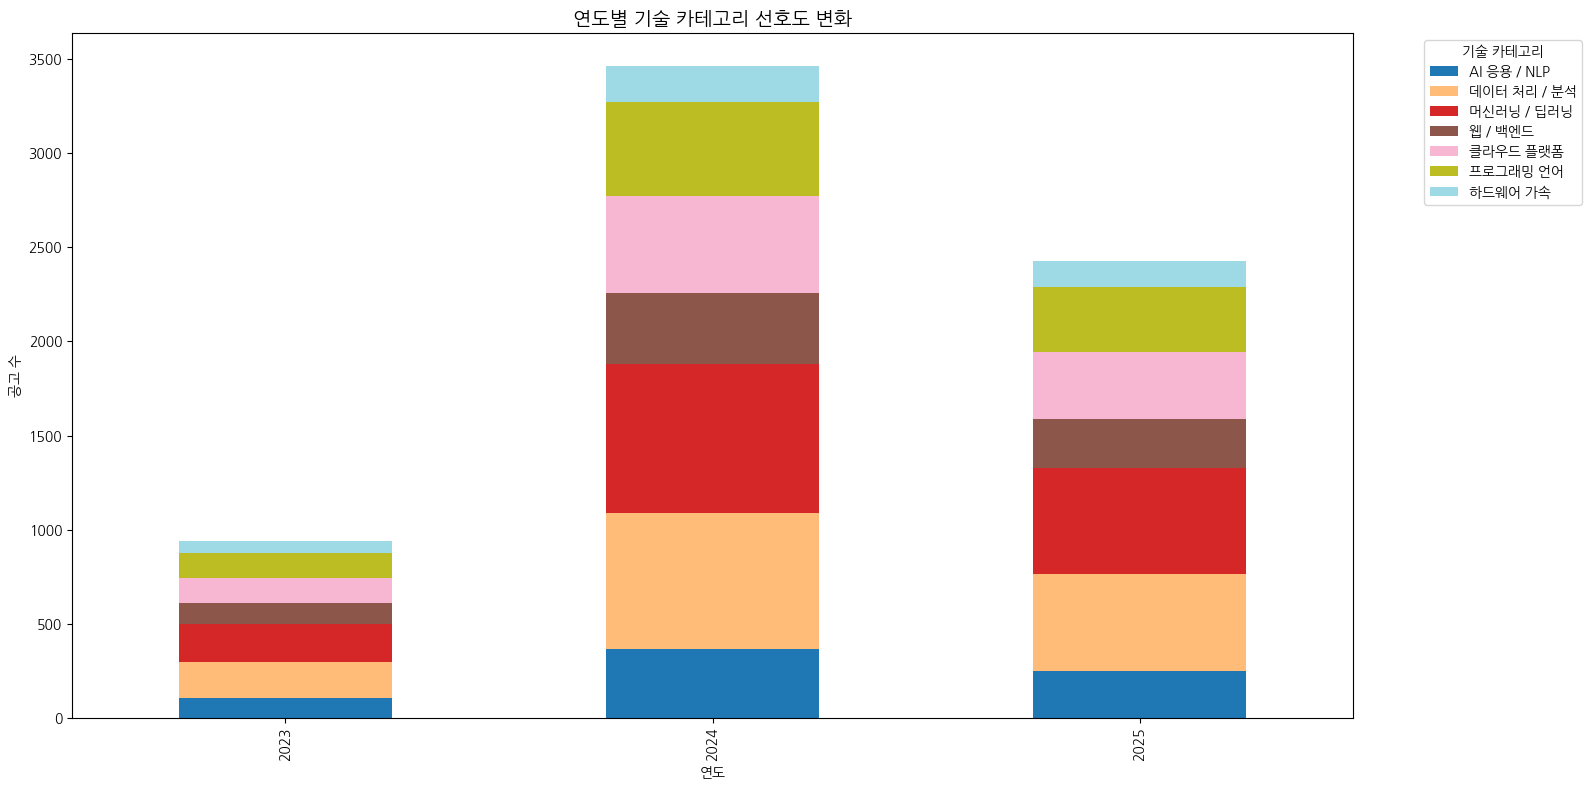

In [12]:
#카테고리별 분류_선호도 변화


import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ CSV 불러오기
df = pd.read_csv("ai_job_market.csv")

# 2️⃣ 날짜 정리
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date', 'skills_required'])
df['year'] = df['posted_date'].dt.year

# 3️⃣ 기술 카테고리 정의
categories = {
    "프로그래밍 언어": ["Python", "C++", "R"],
    "데이터 처리 / 분석": ["Pandas", "NumPy", "SQL", "Excel", "Power BI"],
    "머신러닝 / 딥러닝": ["TensorFlow", "PyTorch", "Scikit-learn", "Keras", "MLflow", "Reinforcement Learning"],
    "AI 응용 / NLP": ["LangChain", "Hugging Face"],
    "웹 / 백엔드": ["FastAPI", "Flask"],
    "클라우드 플랫폼": ["AWS", "Azure", "GCP"],
    "하드웨어 가속": ["CUDA"]
}

# 4️⃣ skills_required 컬럼 분리
df['skills_split'] = df['skills_required'].str.split(r'[,/|]')

# 5️⃣ 카테고리 매핑
def map_category(skill_list):
    found_cats = []
    for skill in skill_list:
        skill = skill.strip()
        for cat, keywords in categories.items():
            if skill in keywords:
                found_cats.append(cat)
    return list(set(found_cats))  # 중복 제거

df['category'] = df['skills_split'].apply(map_category)

# 6️⃣ 카테고리별 연도 빈도 계산
cat_year_counts = (
    df.explode('category')
      .groupby(['year', 'category'])
      .size()
      .unstack(fill_value=0)
)

# 7️⃣ 시각화
plt.figure(figsize=(14,8))
cat_year_counts.plot(kind='bar', stacked=True, colormap='tab20', figsize=(16,8))
plt.title("연도별 기술 카테고리 선호도 변화", fontsize=14)
plt.xlabel("연도")
plt.ylabel("공고 수")
plt.legend(title="기술 카테고리", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


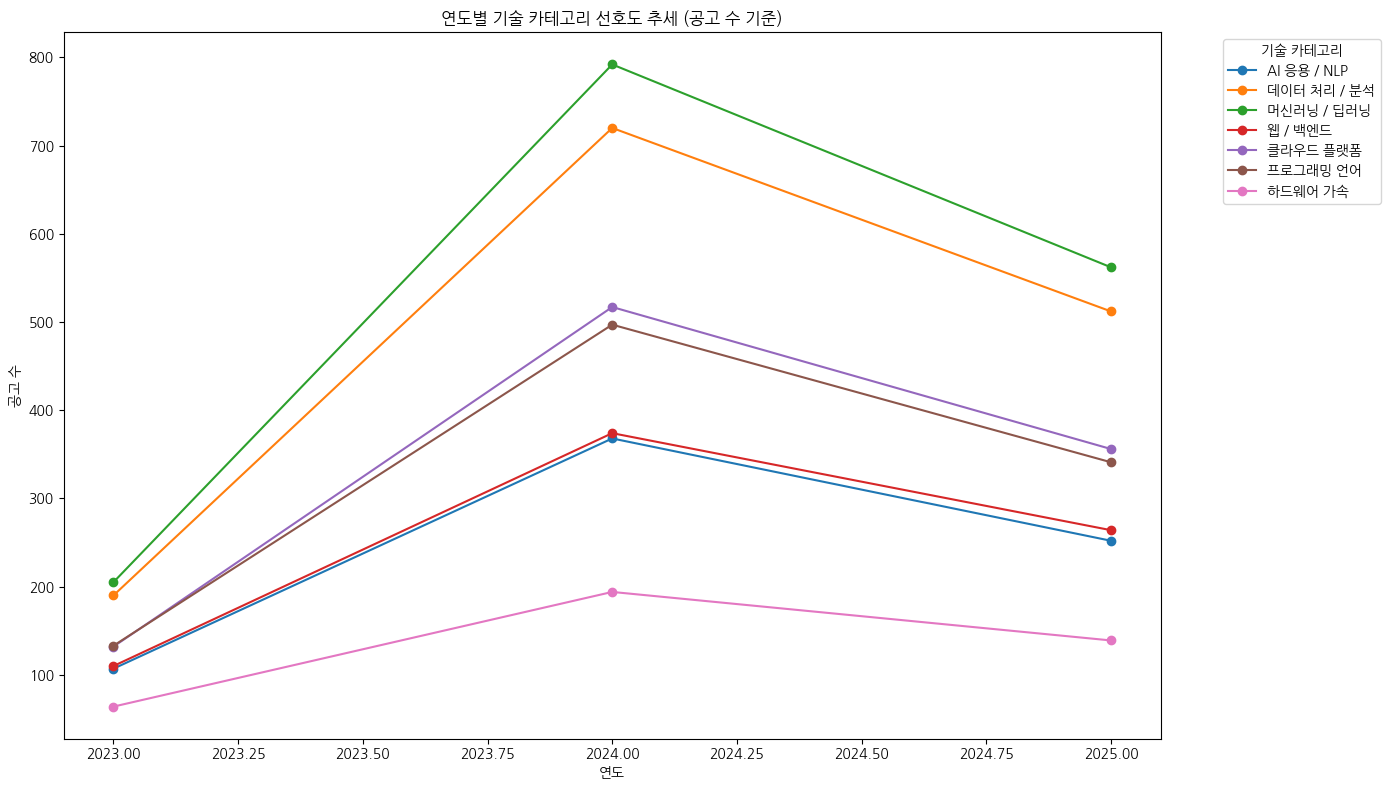

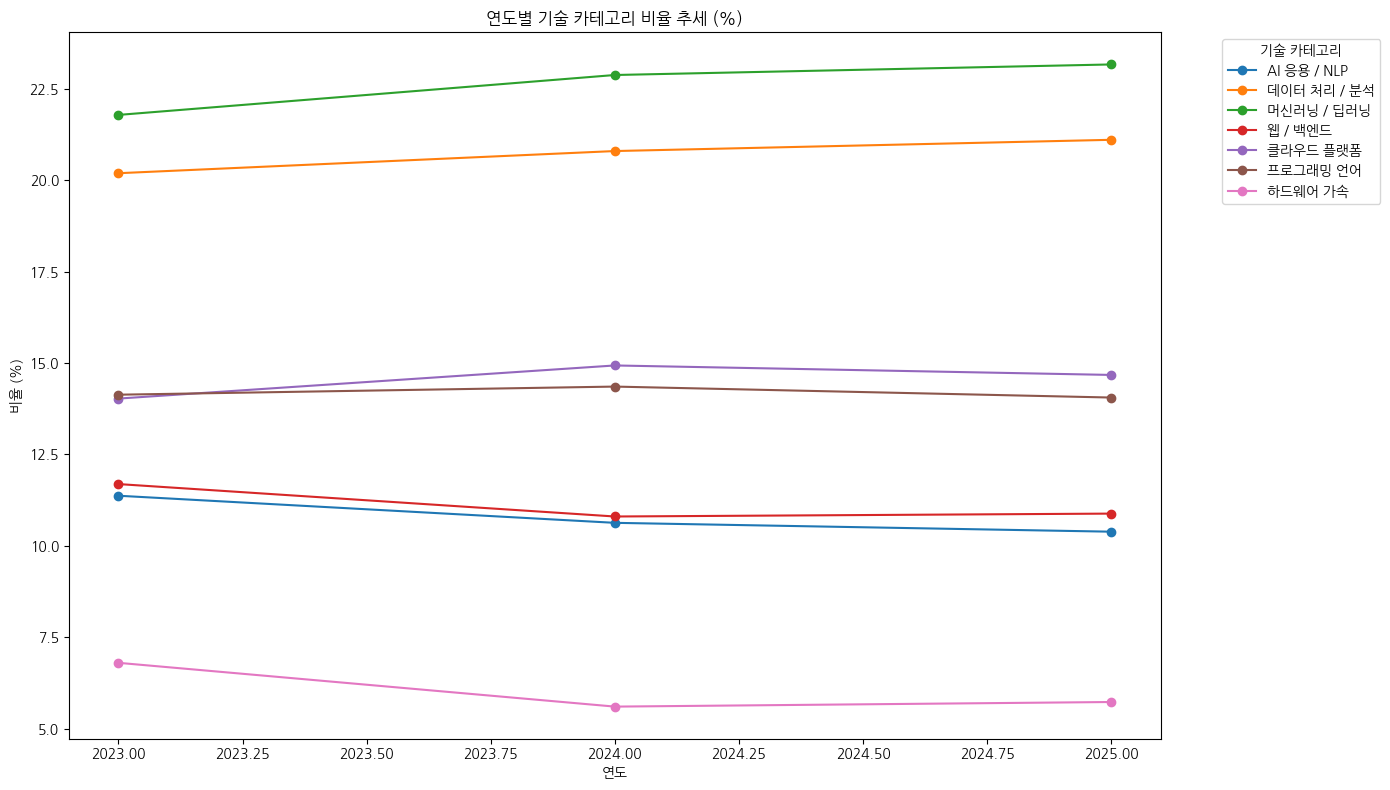

In [13]:
#카테고리별_선호도_비율추세(선그래프)

import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 데이터 불러오기 & 전처리
# =========================
# CSV 경로를 당신의 파일명/경로로 바꾸세요
csv_path = "ai_job_market.csv"
df = pd.read_csv(csv_path)

# posted_date(게시일)를 날짜형으로 바꾸고, 필요한 컬럼 결측치는 제거
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date', 'skills_required'])

# 연도 컬럼 만들기 (예: 2022, 2023)
df['year'] = df['posted_date'].dt.year

# =================================
# 1) 기술 카테고리를 사람이 정의하기
# =================================
# 같은 성질끼리 묶은 사전(딕셔너리)
categories = {
    "프로그래밍 언어": ["Python", "C++", "R"],
    "데이터 처리 / 분석": ["Pandas", "NumPy", "SQL", "Excel", "Power BI"],
    "머신러닝 / 딥러닝": ["TensorFlow", "PyTorch", "Scikit-learn", "Keras", "MLflow", "Reinforcement Learning"],
    "AI 응용 / NLP": ["LangChain", "Hugging Face"],
    "웹 / 백엔드": ["FastAPI", "Flask"],
    "클라우드 플랫폼": ["AWS", "Azure", "GCP"],
    "하드웨어 가속": ["CUDA"]
}

# skills_required 안에 기술이 여러 개 있을 수 있으니 구분자(, / |)로 나누기
df['skills_split'] = df['skills_required'].str.split(r'[,/|]')

# 각 공고의 기술들을 카테고리 이름으로 바꾸는 함수
def map_category(skill_list):
    found_cats = []
    if not isinstance(skill_list, list):
        return found_cats
    for skill in skill_list:
        skill = skill.strip()
        for cat, keywords in categories.items():
            if skill in keywords:
                found_cats.append(cat)
    # 같은 카테고리가 중복 기록되지 않도록 세트로 중복 제거
    return list(set(found_cats))

df['category'] = df['skills_split'].apply(map_category)

# ==========================================
# 2) 연도별 × 카테고리별 공고 수 피벗테이블 만들기
# ==========================================
# category 리스트를 행으로 펼친 뒤, 연도-카테고리로 개수 세기
cat_year_counts = (
    df.explode('category')
      .groupby(['year', 'category'])
      .size()
      .unstack(fill_value=0)  # 열: 카테고리, 값: 공고 수
)

# 연도별 전체 대비 카테고리 비율(%) 계산
cat_year_ratio = cat_year_counts.div(cat_year_counts.sum(axis=1), axis=0) * 100

# =======================================
# 3) 그래프 1 — 카테고리별 추세선 (공고 수)
# =======================================
plt.figure(figsize=(14, 8))
for col in cat_year_counts.columns:
    plt.plot(cat_year_counts.index, cat_year_counts[col], marker='o', label=col)

plt.title("연도별 기술 카테고리 선호도 추세 (공고 수 기준)")
plt.xlabel("연도")
plt.ylabel("공고 수")
plt.legend(title="기술 카테고리", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# # 저장하고 싶다면 주석 해제
# plt.savefig("cat_trend_counts.png", dpi=200, bbox_inches="tight")

# =======================================
# 4) 그래프 2 — 카테고리별 비율 추세선 (%)
# =======================================
plt.figure(figsize=(14, 8))
for col in cat_year_ratio.columns:
    plt.plot(cat_year_ratio.index, cat_year_ratio[col], marker='o', label=col)

plt.title("연도별 기술 카테고리 비율 추세 (%)")
plt.xlabel("연도")
plt.ylabel("비율 (%)")
plt.legend(title="기술 카테고리", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# # 저장하고 싶다면 주석 해제
# plt.savefig("cat_trend_ratio.png", dpi=200, bbox_inches="tight")


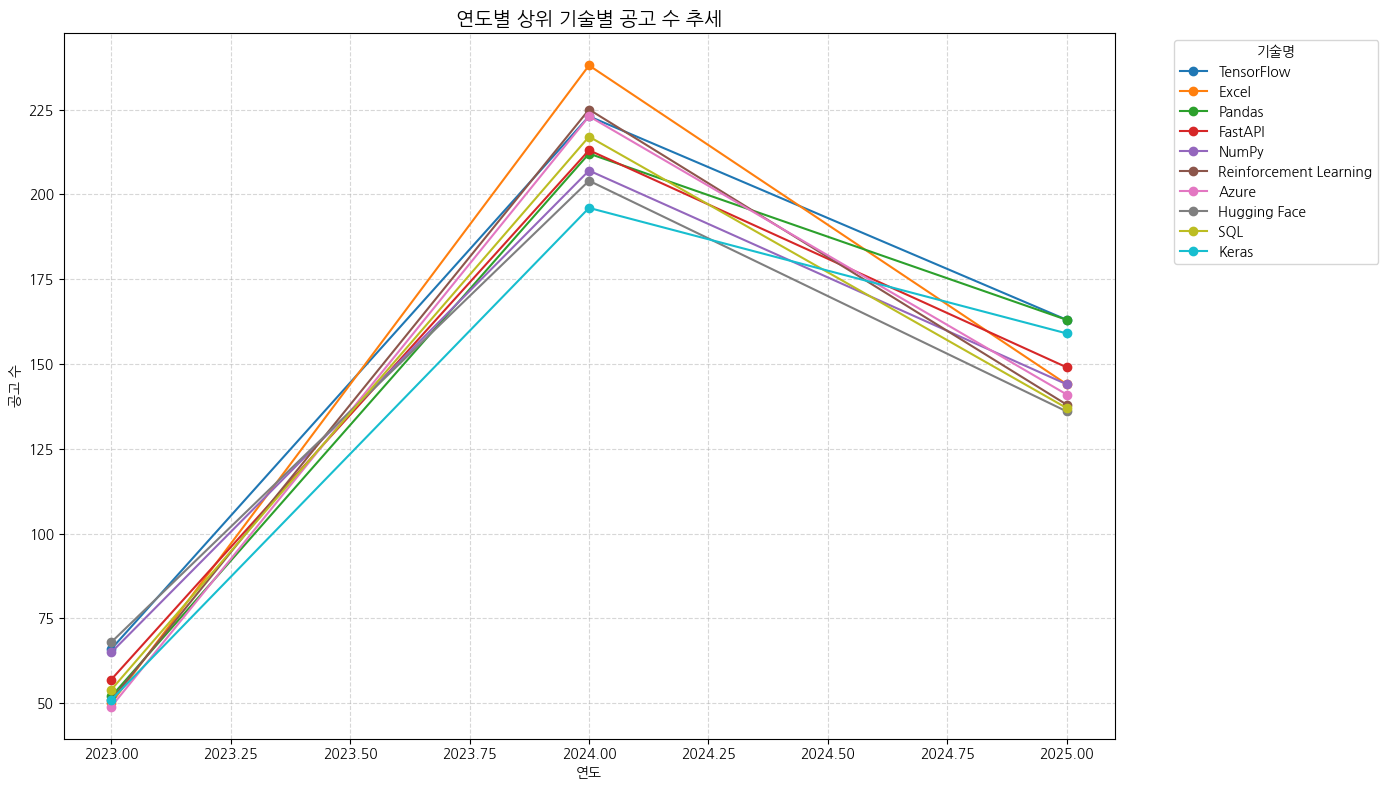

In [14]:
#연도별 스킬 상위10개


import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ 데이터 불러오기 및 전처리
# ==========================================
df = pd.read_csv("ai_job_market.csv")

# 날짜 컬럼을 datetime 형식으로 변환
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')

# 결측치 제거 (날짜, 기술 둘 다 있어야 함)
df = df.dropna(subset=['posted_date', 'skills_required'])

# 연도 추출
df['year'] = df['posted_date'].dt.year

# ==========================================
# 2️⃣ skills_required 열을 개별 기술로 분리
# ==========================================
# 쉼표, /, | 등으로 구분되어 있을 수 있음
df['skills_split'] = df['skills_required'].str.split(r'[,/|]')

# 리스트를 행으로 펼쳐서(=explode) 기술 단위로 변환
df_exploded = df.explode('skills_split')

# 공백 제거 및 비어 있는 값 제거
df_exploded['skills_split'] = df_exploded['skills_split'].str.strip()
df_exploded = df_exploded[df_exploded['skills_split'] != ""]

# ==========================================
# 3️⃣ 연도별, 기술별 공고 수 집계
# ==========================================
skill_year_counts = (
    df_exploded.groupby(['year', 'skills_split'])
               .size()
               .unstack(fill_value=0)
)

# ==========================================
# 4️⃣ 상위 N개 기술만 선택 (그래프가 너무 복잡하지 않게)
# ==========================================
top_skills = skill_year_counts.sum().sort_values(ascending=False).head(10).index
skill_year_counts = skill_year_counts[top_skills]

# ==========================================
# 5️⃣ 선그래프 시각화
# ==========================================
plt.figure(figsize=(14,8))

for skill in top_skills:
    plt.plot(skill_year_counts.index, skill_year_counts[skill], marker='o', label=skill)

plt.title("연도별 상위 기술별 공고 수 추세", fontsize=14)
plt.xlabel("연도")
plt.ylabel("공고 수")
plt.legend(title="기술명", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


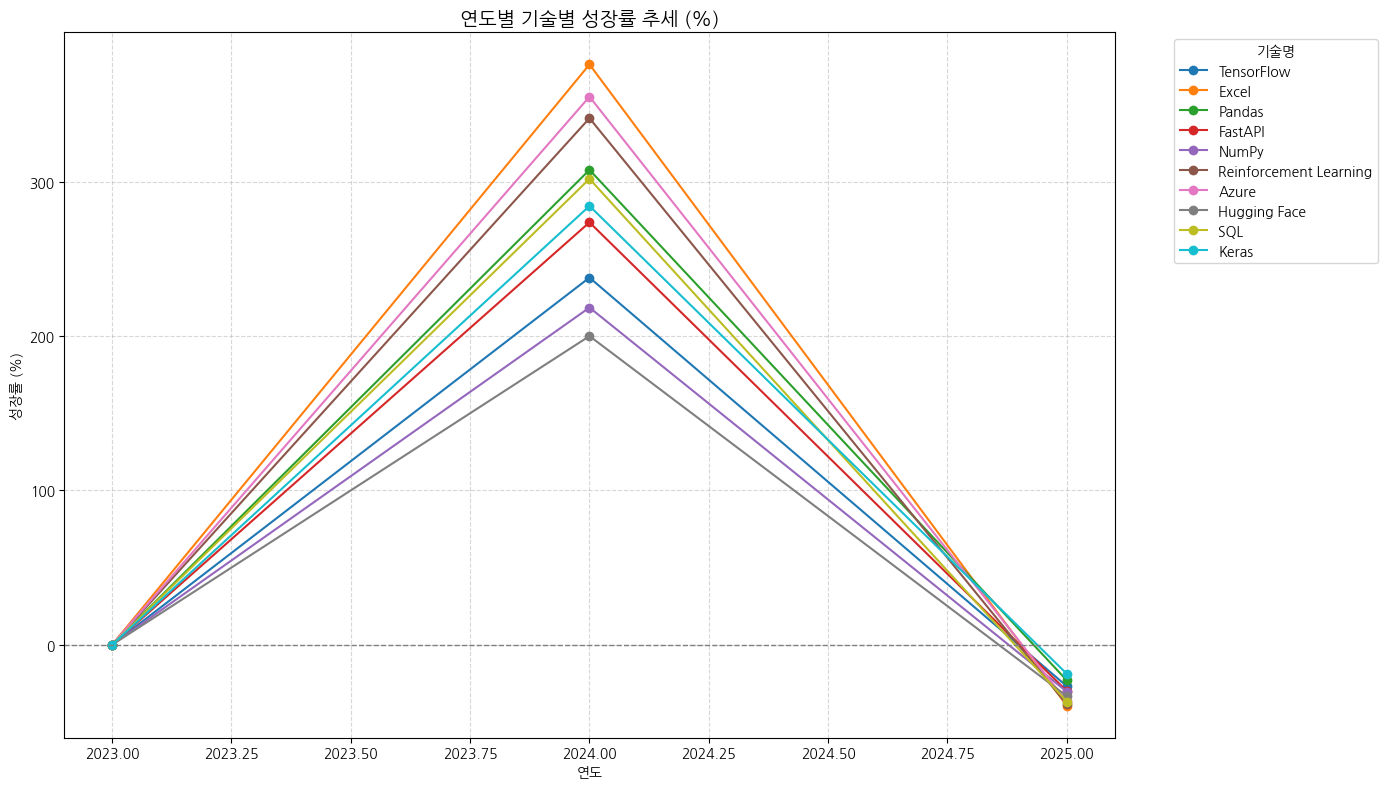

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1️⃣ 데이터 불러오기 및 전처리
# ==========================================
df = pd.read_csv("ai_job_market.csv")

# posted_date를 날짜로 변환
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')

# 날짜, 기술 결측치 제거
df = df.dropna(subset=['posted_date', 'skills_required'])

# 연도 추출
df['year'] = df['posted_date'].dt.year

# ==========================================
# 2️⃣ skills_required를 개별 기술로 분리
# ==========================================
df['skills_split'] = df['skills_required'].str.split(r'[,/|]')
df_exploded = df.explode('skills_split')
df_exploded['skills_split'] = df_exploded['skills_split'].str.strip()
df_exploded = df_exploded[df_exploded['skills_split'] != ""]

# ==========================================
# 3️⃣ 연도별 기술별 공고 수 집계
# ==========================================
skill_year_counts = (
    df_exploded.groupby(['year', 'skills_split'])
               .size()
               .unstack(fill_value=0)
)

# ==========================================
# 4️⃣ 상위 N개 기술만 선택 (그래프 복잡도 조절)
# ==========================================
top_skills = skill_year_counts.sum().sort_values(ascending=False).head(10).index
skill_year_counts = skill_year_counts[top_skills]

# ==========================================
# 5️⃣ 연도별 성장률(%) 계산
# ==========================================
# pct_change()는 (올해-작년)/작년 * 100 계산
skill_growth = skill_year_counts.pct_change() * 100

# 결측값(NaN) → 0으로 대체 (첫해는 비교할 전년 데이터 없음)
skill_growth = skill_growth.fillna(0)

# ==========================================
# 6️⃣ 성장률 선그래프 시각화
# ==========================================
plt.figure(figsize=(14, 8))
for skill in top_skills:
    plt.plot(skill_growth.index, skill_growth[skill], marker='o', label=skill)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # 0% 기준선
plt.title("연도별 기술별 성장률 추세 (%)", fontsize=14)
plt.xlabel("연도")
plt.ylabel("성장률 (%)")
plt.legend(title="기술명", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
